# Домашняя работа 3. Логистическая регрессия.

### Оценивание и штрафы

Максимальная оценка — 10 баллов.

Не списывайте, иначе всем участникам обнулим :)

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка: 10)**

In [131]:
print('Всем удачи!👒')

Всем удачи!👒


In [132]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Логистическая регрессия

Модель логистической регрессии:
  $$
  \hat y = \sigma (Xw).
  $$
  Сигмоида меняется в пределах от 0 до 1 и имеет вид:
  $$
  \sigma(x) = \frac{1}{1+e^{-x}}.
  $$

  Функция потерь log-loss:
  $$
  L = -\frac{1}{\ell}\sum_{i = 1}^{\ell}(y_i\log(\hat y_i) + (1 - y_i)\log(1 - \hat y_i)),
  $$
  где $\ell$ - количество объектов.

## Градиентный спуск

Итеративный метод оптимизации, при котором вектор весов модели $\mathbf{w}^{(t+1)}$ на шаге $t+1$ может быть выражен как:
$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta_t \nabla L(\mathbf{w}^{(t)}),
$$
где $\eta_t$ - шаг обучения.

## Часть 1. Логрег своими руками

**Задание 1 (8 баллов)**. Реализуйте логистическую регрессию, обучаемую с помощью:
- градиентного спуска **(4 балла)**

- стохастического градиентного спуска **(4 балла)**

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавим атрибут класса `loss_history`. В нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [133]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-4,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Args:
          gd_type: Type of gradient descent ('full' or 'stochastic').

          tolerance: Threshold for stopping gradient descent.

          max_iter: Maximum number of steps in gradient descent.

          eta: Learning rate.

          w0: Array of shape d (d — number of weights to optimize).
              Initial weights.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None

    def fit(self, X: np.array, y: np.array) -> LogReg:
        """Fit the model on training data. Also, save value of loss after each iteration.

        Args:
          X: Training data.

          y: Target.

        Returns:
          self: Fitted classsifier.
        """

        if not isinstance(self.w0, np.ndarray):
            self.w0 = np.zeros(X.shape[1])
        step_size=self.eta
        num_steps = self.max_iter
        break_value = self.tolerance
        self.w = self.w0.copy()
        self.w_list = [self.w0]

        self.loss_history = [self.calc_loss(X, y)]

        n = X.shape[0]  # number of objects

        # full gradient descent
        if self.gd_type == 'full':
            for itr in range(num_steps):
                self.w -= step_size * self.calc_gradient(X, y)
                self.loss_history.append(self.calc_loss(X, y))
                self.w_list.append(self.w.copy())
                if np.linalg.norm(step_size * self.calc_gradient(X, y)) < break_value:
                    break
        # stochastic gradient descent
        else:
            for itr in range(num_steps):
                i = np.random.randint(0, n)
                X_i = X[i].reshape(1, -1)
                y_i = y[i]
                self.w -= step_size * self.calc_gradient(X_i, y_i)
                self.loss_history.append(self.calc_loss(X, y))
                self.w_list.append(self.w.copy())
                if np.linalg.norm(step_size * self.calc_gradient(X_i, y_i)) < break_value:
                    break
        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Calculate probability of positive and negative class for each observation.

        Args:
          X: Array of shape (n, d).
             Data.

        Returns:
             Array of shape (n, 2).
             Predicted probabilities.
        """

        if self.w is None:
            raise Exception('Not trained yet')

        predictions_positive = self.sigmoid_function(np.dot(X, self.w))
        predictions_negative = 1 - predictions_positive
        result = np.vstack((predictions_positive, predictions_negative)).T
        return result


    def predict(self, X: np.array) -> np.array:
        """Predict class for each observation.

        Args:
          X: Array of shape (n, d).
             Data.

        Returns:
             Array of shape (n,).
             Predicted class labels.
        """
        if self.w is None:
            raise Exception('Not trained yet')

        predictions = self.sigmoid_function(np.dot(X, self.w))
        result = np.vectorize(lambda x: 1 if x >= 0.5 else 0)(predictions)
        return result

    def sigmoid_function(self, z: np.array):
        values = 1 / (1 + np.exp(-z))
        return values

    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Calculate gradient of loss function after each iteration.

        Args:
          X: Array of shape (n, d), n can be equal to 1 if 'stochastic'.
          y: Array of shape (n,).

        Returns:
          Array of shape (d,).
          Gradient of loss function after current iteration.
        """

        # LogLoss = -1/n(y^T log(Xw) + (1-y)^T log(1-Xw))
        y_predictions = self.sigmoid_function(np.dot(X, self.w))
        gradient = np.dot(X.T, y_predictions - y) / X.shape[0]
        return gradient

    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Calculate value of loss function after each iteration.

        Args:
          X: Array of shape (n, d).
          y: Array of shape (n,).

        Returns:
          Value of loss function after current iteration.
        """
        y_predictions = self.sigmoid_function(np.dot(X, self.w))
        loss = -np.mean(y * np.log(y_predictions) + (1 - y) * np.log(1 - y_predictions))
        return loss

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем синтетические данные.

In [134]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Задание 2 (1 балл).** Обучите логистическую регрессию на синтетических данных. Нарисуйте кривую обучения.

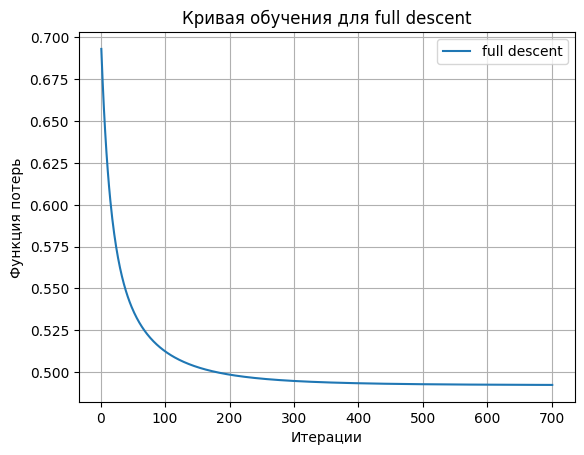

In [135]:
logreg = LogReg('full')
logreg.fit(X_train, y_train)
result = logreg.predict_proba(X_train)

plt.plot(np.arange(len(logreg.loss_history))+1, logreg.loss_history, label='full descent')
plt.xlabel("Итерации")
plt.ylabel("Функция потерь")
plt.title("Кривая обучения для full descent")
plt.grid(True)
plt.legend()
plt.show()

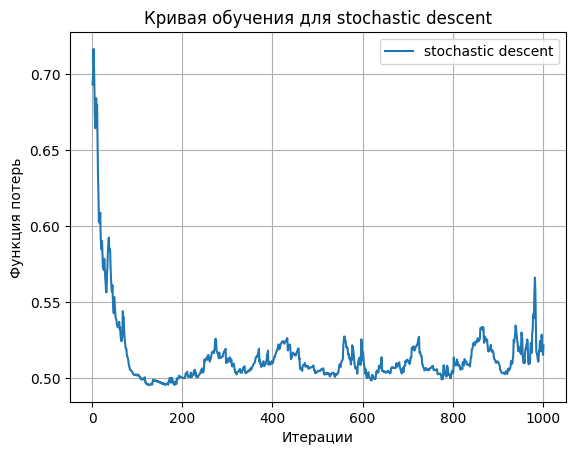

In [136]:
logreg_s = LogReg('stochastic')
logreg_s.fit(X_train, y_train)
result = logreg_s.predict_proba(X_train)

plt.plot(np.arange(len(logreg_s.loss_history))+1, logreg_s.loss_history, label='stochastic descent')
plt.xlabel("Итерации")
plt.ylabel("Функция потерь")
plt.title("Кривая обучения для stochastic descent")
plt.grid(True)
plt.legend()
plt.show()

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые.

ROC AUC: 0.845350358334915


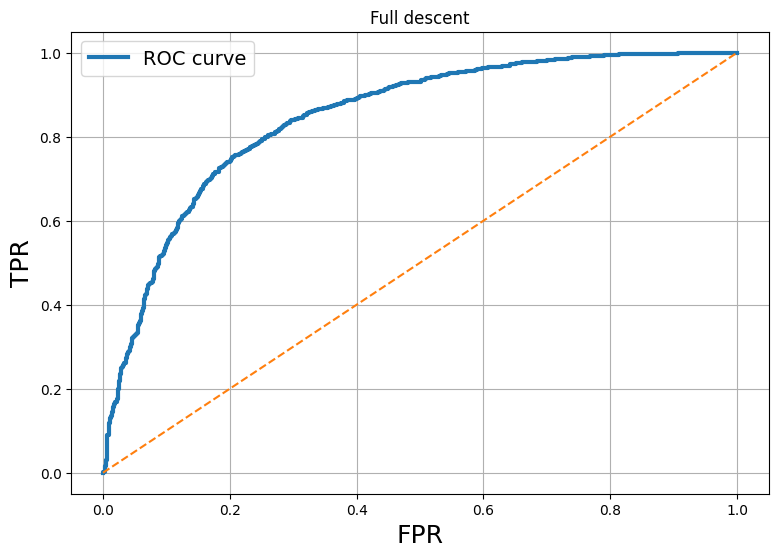

In [137]:
from sklearn.metrics import roc_curve, auc
# full descent

predictions_test = logreg.predict_proba(X_test)[:, 0]
fpr, tpr, _ = roc_curve(y_test, predictions_test)
auc = auc(fpr, tpr)
print(f'ROC AUC: {auc}')

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, linewidth=3, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('Full descent')
plt.xlabel('FPR', size=18)
plt.ylabel('TPR', size=18)

plt.legend(loc='best', fontsize=14)
plt.grid()
plt.show()

ROC AUC: 0.8315250269923559


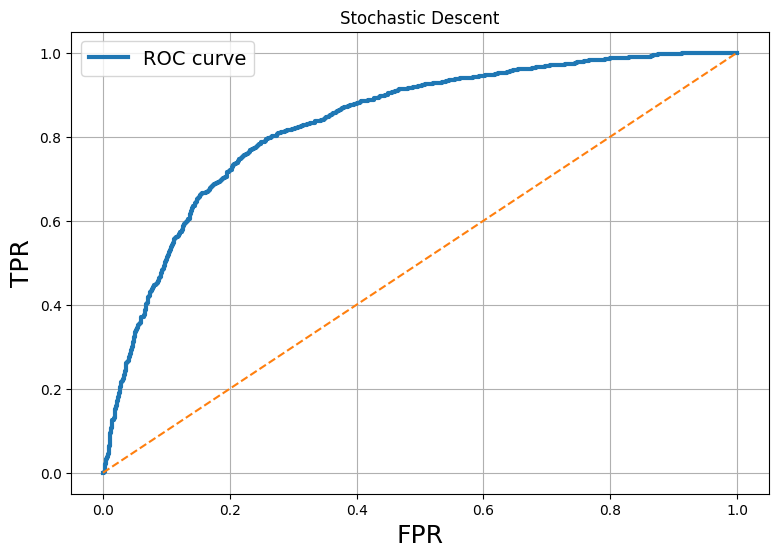

In [138]:
from sklearn.metrics import auc
# stochastic descent

predictions_test = logreg_s.predict_proba(X_test)[:, 0]
fpr, tpr, _ = roc_curve(y_test, predictions_test)
auc = auc(fpr, tpr)
print(f'ROC AUC: {auc}')

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, linewidth=3, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('Stochastic Descent')
plt.xlabel('FPR', size=18)
plt.ylabel('TPR', size=18)

plt.legend(loc='best', fontsize=14)
plt.grid()
plt.show()

PR AUC: 0.8046370795799731


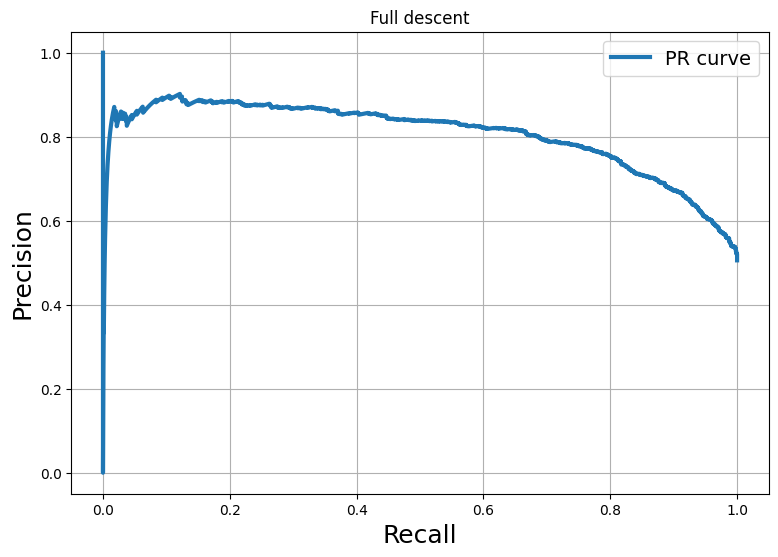

In [139]:
from sklearn.metrics import precision_recall_curve, auc
# full descent

precision, recall, _ = precision_recall_curve(y_test, predictions_test)
auc = auc(recall, precision)
print(f'PR AUC: {auc}')

plt.figure(figsize=(9, 6))
plt.plot(recall, precision, linewidth=3, label='PR curve')
plt.title('Full descent')

plt.xlabel('Recall', size=18)
plt.ylabel('Precision', size=18)

plt.legend(loc='best', fontsize=14)
plt.grid()
plt.show()

PR AUC: 0.8046370795799731


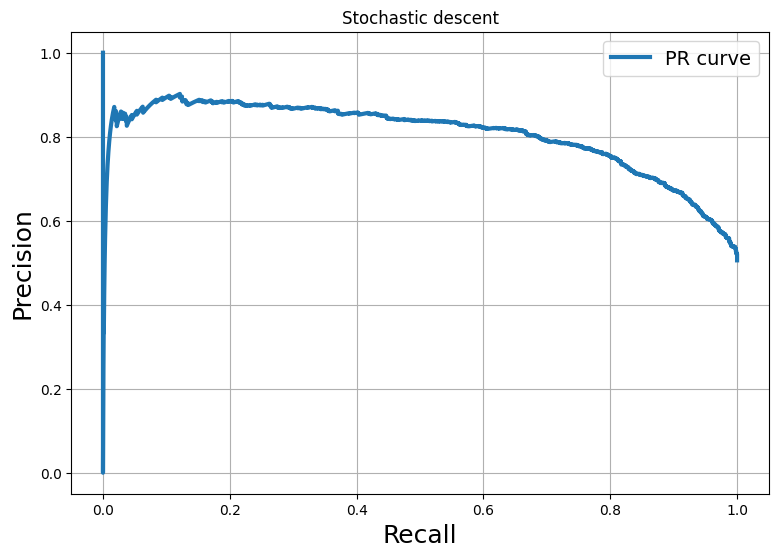

In [140]:
from sklearn.metrics import auc
# stochastic descent

precision, recall, _ = precision_recall_curve(y_test, predictions_test)
auc = auc(recall, precision)
print(f'PR AUC: {auc}')

plt.figure(figsize=(9, 6))
plt.plot(recall, precision, linewidth=3, label='PR curve')
plt.title('Stochastic descent')

plt.xlabel('Recall', size=18)
plt.ylabel('Precision', size=18)

plt.legend(loc='best', fontsize=14)
plt.grid()
plt.show()

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс валидации.  

In [141]:
from sklearn.model_selection import KFold
from sklearn.metrics import auc

k = 5  # количество разбиений
kf = KFold(n_splits=k, shuffle=True, random_state=24)

roc_auc_scores_full = []
pr_auc_scores_full = []
roc_auc_scores_st = []
pr_auc_scores_st = []
logreg = LogReg('full')
logreg_s = LogReg('stochastic')

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    logreg.fit(X_train, y_train)
    logreg_s.fit(X_train, y_train)

    y_pred_full = logreg.predict_proba(X_test)[:, 0]
    y_pred_st = logreg_s.predict_proba(X_test)[:, 0]

    fpr_full, tpr_full, _ = roc_curve(y_test, y_pred_full)
    auc_roc_full = auc(fpr_full, tpr_full)
    fpr_st, tpr_st, _ = roc_curve(y_test, y_pred_st)
    auc_roc_st = auc(fpr_st, tpr_st)

    precision_full, recall_full, _ = precision_recall_curve(y_test, y_pred_full)
    auc_pr_full = auc(recall_full, precision_full)
    precision_st, recall_st, _ = precision_recall_curve(y_test, y_pred_st)
    auc_pr_st = auc(recall_st, precision_st)

    roc_auc_scores_full.append(auc_roc_full)
    pr_auc_scores_full.append(auc_pr_full)
    roc_auc_scores_st.append(auc_roc_st)
    pr_auc_scores_st.append(auc_pr_st)

print("Full Gradient Descent:")
print(f"Mean ROC-AUC: {np.mean(roc_auc_scores_full):.4f}, Std: {np.std(roc_auc_scores_full):.4f}")
print("Stochastic Gradient Descent:")
print(f"Mean ROC-AUC: {np.mean(roc_auc_scores_st):.4f}, Std: {np.std(roc_auc_scores_st):.4f}")

Full Gradient Descent:
Mean ROC-AUC: 0.8479, Std: 0.0088
Stochastic Gradient Descent:
Mean ROC-AUC: 0.8382, Std: 0.0096
